In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import MITgcmutils as mit
import cmocean 
import xarray as xr
from scipy.spatial import cKDTree
from numba import njit
from matplotlib.colors import Normalize # Normalizeをimport
from matplotlib.colors import TwoSlopeNorm
from geopy.distance import great_circle
import cartopy.crs as ccrs
import os
import netCDF4
from matplotlib.tri import Triangulation
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter


In [ ]:
fileloc_IC = '/home/tsuribeh/MITgcm/cases_tsuribeh_bachelor/Straume2020_go.cs32x15/run_St50Ma_CNTL/'
fileloc_to_write = '/home/tsuribeh/MITgcm/cases_tsuribeh_master/St50Ma_OCN/input/'

In [3]:
XC = mit.rdmds(fileloc_IC+'XC')
YC = mit.rdmds(fileloc_IC+'YC')
XCYC = np.stack([XC,YC],axis=2)

lon_ = np.linspace(-180,180,361)
lat_ = np.linspace(-90,90,181)
lon, lat = np.meshgrid(lon_, lat_)

triang = tri.Triangulation(XC.flatten(), YC.flatten())

In [4]:
DXC = mit.rdmds(fileloc_IC+'DXC')
DYC = mit.rdmds(fileloc_IC+'DYC')
DRF = mit.rdmds(fileloc_IC+'DRF')
hFacC = mit.rdmds(fileloc_IC+'hFacC')
DVC = DXC*DYC*DRF*hFacC


In [5]:
Eta_ini = mit.rdmds(fileloc_IC + 'Eta',7200000)
U_ini = mit.rdmds(fileloc_IC + 'U',7200000)
V_ini = mit.rdmds(fileloc_IC + 'V',7200000)
T_ini = mit.rdmds(fileloc_IC + 'T',7200000)
S_ini = mit.rdmds(fileloc_IC + 'S',7200000)



TauX = mit.readbin(fileloc_IC+'trenberth_TauX_polar_averaged_sym.bin', (12,32,192), dataprec='float64')
TauY = mit.readbin(fileloc_IC+'trenberth_TauY_averaged_antisym.bin', (12,32,192), dataprec='float64')

In [56]:
mit.writebin(fileloc_to_write+'Eta_St50MaCNTL_20000yrs.bin', Eta_ini, dataprec='float64')
mit.writebin(fileloc_to_write+'U_St50MaCNTL_20000yrs.bin', U_ini, dataprec='float64')
mit.writebin(fileloc_to_write+'V_St50MaCNTL_20000yrs.bin', V_ini, dataprec='float64')
mit.writebin(fileloc_to_write+'T_St50MaCNTL_20000yrs.bin', T_ini, dataprec='float64')
mit.writebin(fileloc_to_write+'S_St50MaCNTL_20000yrs.bin', S_ini, dataprec='float64')


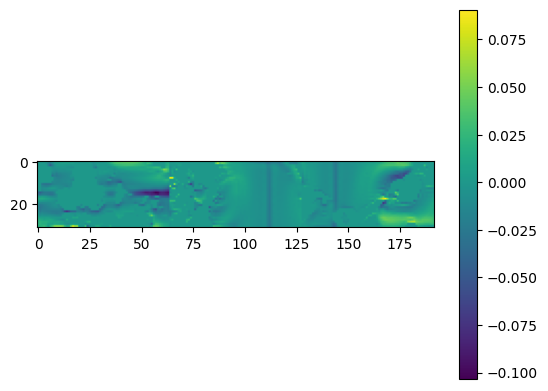

In [7]:
# plt.imshow(Eta_ini)
plt.imshow(U_ini[0])

plt.colorbar()

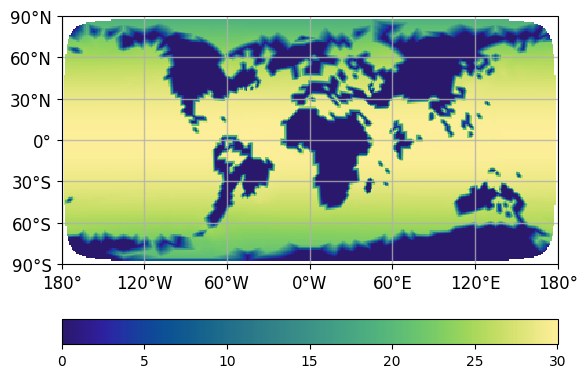

In [8]:
data = T_ini[0]
dmax= max(np.max(data), -np.min(data))

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, data_regrid, vmax= dmax#, vmin =-dmax
    ,cmap=  cmocean.cm.haline
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Temperature [${}^\circ\\mathrm{C}$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

In [136]:
fileloc_Cntl = '/home/tsuribeh/MITgcm/cases_tsuribeh_master/St50Ma_OCN/run/'

In [ ]:
# U = mit.rdmds(fileloc_Cntl+'U', 7200)
# Eta1 = mit.rdmds(fileloc_output+'Eta', 72000-3600)
# Eta2 = mit.rdmds(fileloc_output+'Eta', 72000)

# S = mit.rdmds(fileloc_output+'S', 3600)
# Agetracer =mit.rdmds(fileloc_output+'PTRACER01',72000) #計算できてない



In [364]:
Eta_Cntl = mit.rdmds(fileloc_Cntl + 'Eta',72000)
U_Cntl = mit.rdmds(fileloc_Cntl + 'U',72000)
V_Cntl = mit.rdmds(fileloc_Cntl + 'V',72000)
T_Cntl = mit.rdmds(fileloc_Cntl + 'T',72000)
S_Cntl = mit.rdmds(fileloc_Cntl + 'S',72000)


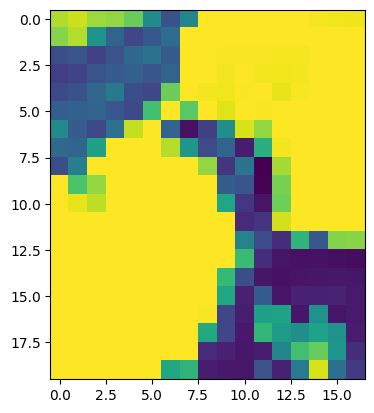

In [365]:
bathy_Cntl = mit.readbin(fileloc_Cntl+'Straume20_St50Ma_cs32.bin', (32,192),dataprec='float64')
plt.imshow(bathy_Cntl[:20,175:])

In [142]:
bathy_Cntl[5,181]

0.0

[5,181]が陸地。水深1080mにする。

In [144]:
bathy_Cntl[4,181]

-1311.4716847903587

In [146]:
bathy_Cntl[6,181]

-3954.5911313721285

In [145]:
bathy_Cntl[5,180]


-1752.8510189390747

In [147]:
bathy_Cntl[5,182]


-1483.4443113795253

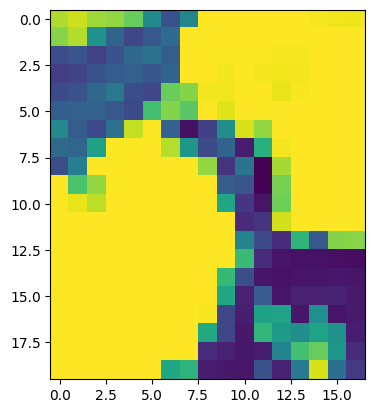

In [366]:
bathy_Tsmn = bathy_Cntl.copy()
bathy_Tsmn[5,181] = -1080.
bathy_Tsmn[4,182] = -1080.

plt.imshow(bathy_Tsmn[:20,175:])


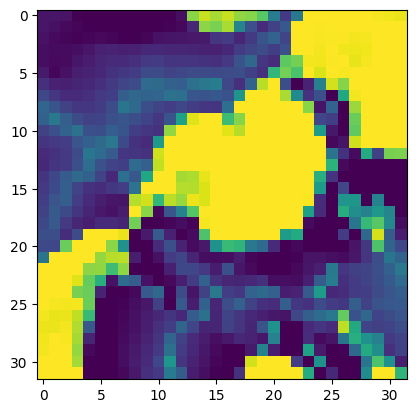

In [367]:
im =plt.imshow(bathy_Tsmn[:,160:],vmax=0., vmin=-5200.)


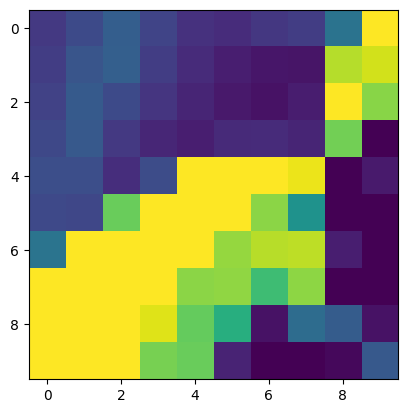

In [343]:
plt.imshow(bathy_Tsmn[15:25,160:170],vmax=0., vmin=-5200.)

In [363]:
bathy_Tsmn[18,168]

-1109.6887323241397

In [372]:
T_TsmnIni = T_Cntl.copy()
S_TsmnIni = S_Cntl.copy()
U_TsmnIni = U_Cntl.copy()
V_TsmnIni = V_Cntl.copy()
Eta_TsmnIni = Eta_Cntl.copy()


In [380]:
T_TsmnIni[:7, 5,181] = (T_Cntl[:7, 5,180]+T_Cntl[:7, 4,181]+T_Cntl[:7, 5,182]+T_Cntl[:7, 6,181])/4.
S_TsmnIni[:7, 5,181] = (S_Cntl[:7, 5,180]+S_Cntl[:7, 4,181]+S_Cntl[:7, 5,182]+S_Cntl[:7, 6,181])/4.
# U_Cntl[:7, 5,181] = (U_Cntl[:7, 5,180]+U_Cntl[:7, 4,181]+U_Cntl[:7, 5,182]+U_Cntl[:7, 6,181])
# V_Cntl[:7, 5,181] = (V_Cntl[:7, 5,180]+V_Cntl[:7, 4,181]+V_Cntl[:7, 5,182]+V_Cntl[:7, 6,181])
# Eta_Cntl[5,181] = (Eta_Cntl[5,180]+Eta_Cntl[4,181]+Eta_Cntl[5,182]+Eta_Cntl[6,181])/4.

T_TsmnIni[:7, 4,182]= (T_Cntl[:7, 5,182]+T_Cntl[:7, 4,181])/2.
S_TsmnIni[:7, 4,182] = (S_Cntl[:7, 5,182]+S_Cntl[:7, 4,181])/2.


In [381]:
fileloc_Tsmn = '/home/tsuribeh/MITgcm/cases_tsuribeh_master/St50Ma_OCN/run_Tsmn/'
mit.writebin(fileloc_Tsmn+'Straume20_St50Ma_cs32_Tsmn1080.bin',bathy_Tsmn,dataprec='float64')
mit.writebin(fileloc_Tsmn+'Eta_St50Ma_OCN_200yrs.bin', Eta_TsmnIni, dataprec='float64')
mit.writebin(fileloc_Tsmn+'U_St50Ma_OCN_200yrs.bin', U_TsmnIni, dataprec='float64')
mit.writebin(fileloc_Tsmn+'V_St50MaC_OCN_200yrs.bin', V_TsmnIni, dataprec='float64')
mit.writebin(fileloc_Tsmn+'T_St50Ma_OCN_200yrs.bin', T_TsmnIni, dataprec='float64')
mit.writebin(fileloc_Tsmn+'S_St50Ma_OCN_200yrs.bin', S_TsmnIni, dataprec='float64')


In [564]:
Years=np.array([i*1000 for i in range(4)])
# Years=500
iter= list(Years*360)
Eta_Tsmn =mit.rdmds(fileloc_Tsmn+'Eta', iter)
# U_Tsmn =mit.rdmds(fileloc_Tsmn+'U', iter)
U_Tsmn =mit.rdmds(fileloc_Tsmn+'U', iter)

V_Tsmn =mit.rdmds(fileloc_Tsmn+'V', iter)

T_Tsmn =mit.rdmds(fileloc_Tsmn+'T', iter)



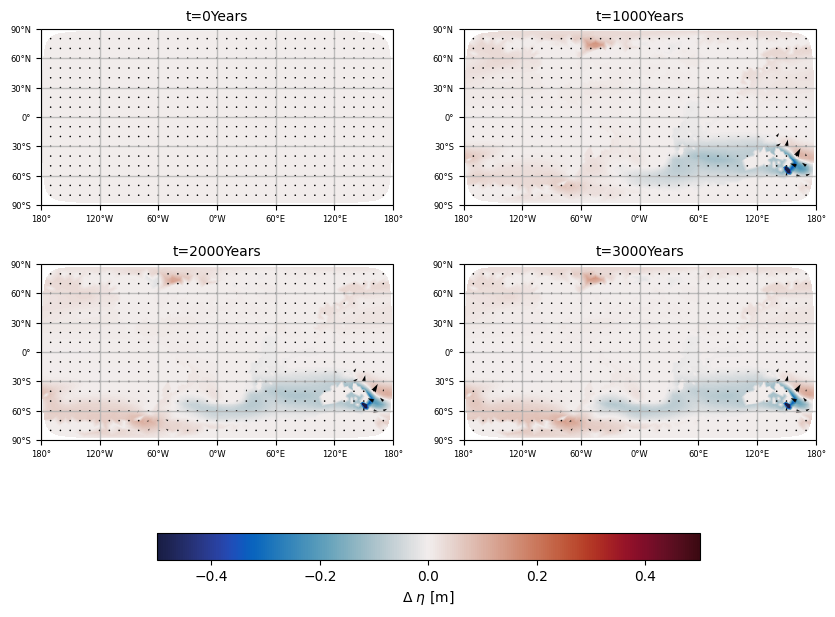

In [565]:
dmax = 0.5
fig = plt.figure(figsize=(10, 8))  # 図のサイズを少し大きく

for j in range(4):
    ax = fig.add_subplot(2, 2, j+1, projection=ccrs.PlateCarree())  # j+1 に修正

    data = Eta_Tsmn[ j] - Eta_Cntl
    interpolator = tri.LinearTriInterpolator(triang, data.flatten())
    data_regrid = interpolator(lon, lat)
    # data_regrid = np.ma.masked_invalid(data_regrid)

    cf = ax.pcolormesh(lon, lat, data_regrid, vmax=dmax, vmin=-dmax,
                       cmap=cmocean.cm.balance)
    depth_idx=3
    Udata = U_Tsmn[j,depth_idx] - U_Cntl[depth_idx]
    Vdata = V_Tsmn[j,depth_idx] - V_Cntl[depth_idx]
    interpolator_U = tri.LinearTriInterpolator(triang, Udata.flatten())
    Udata_regrid = interpolator_U(lon, lat)
    # data_regrid = np.ma.masked_invalid(data_regrid)
    interpolator_V = tri.LinearTriInterpolator(triang, Vdata.flatten())
    Vdata_regrid = interpolator_V(lon, lat)
    # data_regrid = np.ma.masked_invalid(data_regrid)
    skip=10
    qv = ax.quiver(lon[::skip,::skip],lat[::skip,::skip],Udata_regrid[::skip,::skip], Vdata_regrid[::skip,::skip],
              scale=1, color="black", width=0.005, transform=ccrs.PlateCarree())

    dlon, dlat = 60, 30
    xticks = np.arange(-180, 180.1, dlon)
    yticks = np.arange(-90, 90.1, dlat)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=1, alpha=0.8)
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    lonfmt = LongitudeFormatter(zero_direction_label=True)
    latfmt = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lonfmt)
    ax.yaxis.set_major_formatter(latfmt)
    ax.tick_params(labelsize=6)
    # タイトルを追加（必要に応じて時刻などに書き換えてください）
    ax.set_title("t="+ str(Years[j])+'Years', fontsize=10)

cb = fig.colorbar(cf, ax= fig.axes, orientation="horizontal", shrink=0.7)
cb.set_label("$\Delta$ $\eta$ [m]", fontsize=10)



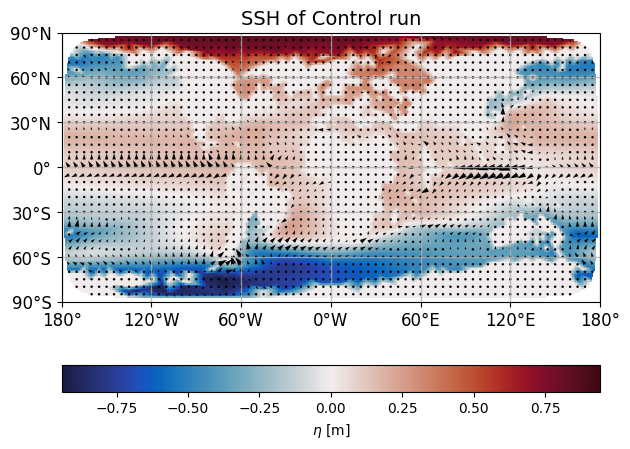

In [545]:
data = Eta_Cntl
# data = U_Cntl[0]

dmax= max(np.max(data), -np.min(data))

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, data_regrid, vmax= dmax, vmin =-dmax
    ,cmap=  cmocean.cm.balance
                   )

Udata = U_Cntl[0]
Vdata = V_Cntl[0]
interpolator_U = tri.LinearTriInterpolator(triang, Udata.flatten())
Udata_regrid = interpolator_U(lon, lat)
# data_regrid = np.ma.masked_invalid(data_regrid)
interpolator_V = tri.LinearTriInterpolator(triang, Vdata.flatten())
Vdata_regrid = interpolator_V(lon, lat)
# data_regrid = np.ma.masked_invalid(data_regrid)
skip=5
qv = ax.quiver(lon[::skip,::skip],lat[::skip,::skip],Udata_regrid[::skip,::skip], Vdata_regrid[::skip,::skip],
            scale=5, color="black", width=0.005, transform=ccrs.PlateCarree())

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#タイトルを追加（ここを変更）
ax.set_title("SSH of Control run", fontsize=14)
fig.tight_layout()

Text(0.5, 1.0, 'Temperature change between ')

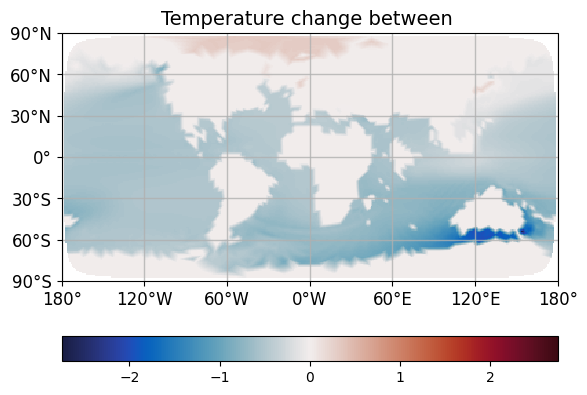

In [571]:
# data = Eta_Tsmn
T_Tsmn =mit.rdmds(fileloc_Tsmn+'T', 2900*360)

# data = Eta_Cntl
depth_idx=7
data =T_Tsmn[depth_idx] - T_Cntl[depth_idx]

dmax= max(np.max(data), -np.min(data))

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, data_regrid, vmax= dmax, vmin =-dmax
    ,cmap=  cmocean.cm.balance
                   )

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
# cb.set_label("Temperature [${}^\circ\\mathrm{C}$]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)
ax.set_title("Temperature change between ", fontsize=14)


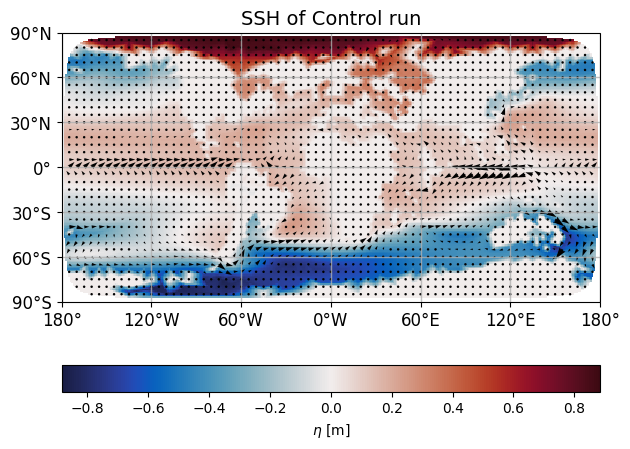

In [572]:
U_Diag =mit.rdmds(fileloc_Tsmn+'dynDiag',360*3000)[6]
V_Diag =mit.rdmds(fileloc_Tsmn+'dynDiag',360*3000)[7]

data = Eta_Tsmn[-1]
# data = U_Cntl[0]

dmax= max(np.max(data), -np.min(data))

interpolator = tri.LinearTriInterpolator(triang, data.flatten())
data_regrid = interpolator(lon, lat)

fig = plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ax.pcolormesh(lon,lat, data_regrid, vmax= dmax, vmin =-dmax
    ,cmap=  cmocean.cm.balance
                   )

Udata = U_Diag[0]
Vdata = V_Diag[0]
interpolator_U = tri.LinearTriInterpolator(triang, Udata.flatten())
Udata_regrid = interpolator_U(lon, lat)
# data_regrid = np.ma.masked_invalid(data_regrid)
interpolator_V = tri.LinearTriInterpolator(triang, Vdata.flatten())
Vdata_regrid = interpolator_V(lon, lat)
# data_regrid = np.ma.masked_invalid(data_regrid)
skip=5
qv = ax.quiver(lon[::skip,::skip],lat[::skip,::skip],Udata_regrid[::skip,::skip], Vdata_regrid[::skip,::skip],
            scale=5, color="black", width=0.005, transform=ccrs.PlateCarree())

# カラーバーを追加
cb = fig.colorbar(cf, ax=ax, orientation="horizontal")
cb.set_label("$\eta$ [m]")

#グリッドと軸目盛を描く緯度経度を設定するための配列
dlon,dlat=60,30
xticks=np.arange(-180,180.1,dlon)
yticks=np.arange(-90,90.1,dlat)

#グリッド線を引く
gl = ax.gridlines(crs=ccrs.PlateCarree()
         , draw_labels=False
         , linewidth=1, alpha=0.8)
gl.xlocator = mticker.FixedLocator(xticks)    
gl.ylocator = mticker.FixedLocator(yticks)
#目盛を描く緯度経度の値を設定
ax.set_xticks(xticks,crs=ccrs.PlateCarree())
ax.set_yticks(yticks,crs=ccrs.PlateCarree())

# 目盛の表示形式を度数表記にする    
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lonfmt)
ax.yaxis.set_major_formatter(latfmt)
#目盛のサイズを指定
ax.axes.tick_params(labelsize=12)

#タイトルを追加（ここを変更）
ax.set_title("SSH of Control run", fontsize=14)
fig.tight_layout()